In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
from IPython import display as disp
import librosa
import soundfile as sf
import os
import librosa.display

In [3]:
import sys
sys.path.append('..')

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline  

In [5]:
# устанавливаем sample rate
SR = 16000

In [8]:
def get_files(d: str, extentions: list=None):
    """
    extensions: list
    """
    if extentions:
        return [f'{d}/{f}' for f in os.listdir(d) if any([f.endswith(e) for e in extentions])]
    return [f'{d}/{f}' for f in os.listdir(d)]

## vis utils

In [9]:
def plot_waveform(wav: np.ndarray, sr: int, label: str = None, figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    if label:
        fig.suptitle(label, fontsize=16)
    return librosa.display.waveshow(wav, sr=sr, ax=ax)

def plot_mel(wav: np.ndarray, sr: int, label: str = None, figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    if label:
        fig.suptitle(label, fontsize=16)
    S = librosa.feature.melspectrogram(y=wav, sr=sr)
    return librosa.display.specshow(librosa.power_to_db(S, ref=np.max), ax=ax)

## EDA

In [14]:
df = df[df.status == 'APPROVED'].sample(1000)

In [15]:
path = f"{DATA_PATH}/{sample['path'].item()}"

In [16]:
disp.display(disp.Audio(path))
print(sample['text'].item())

Статья Код: ATBLAM ATBLAM модуль идентичен модулю ATLAM.


In [18]:
wav, sr = librosa.load(path)

In [20]:
mel = librosa.feature.melspectrogram(y=wav, sr=sr)

In [21]:
res = librosa.feature.inverse.mel_to_audio(mel, 
                                           sr=sr,
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='constant', 
                                           power=1.0, 
                                           n_iter=32,
                                          )

In [22]:
# step4 - save it as a wav file
import soundfile as sf
sf.write("data/back_to_wav.wav", res, sr)

In [23]:
disp.display(disp.Audio('data/back_to_wav.wav'))

In [24]:
wav.shape

(187384,)

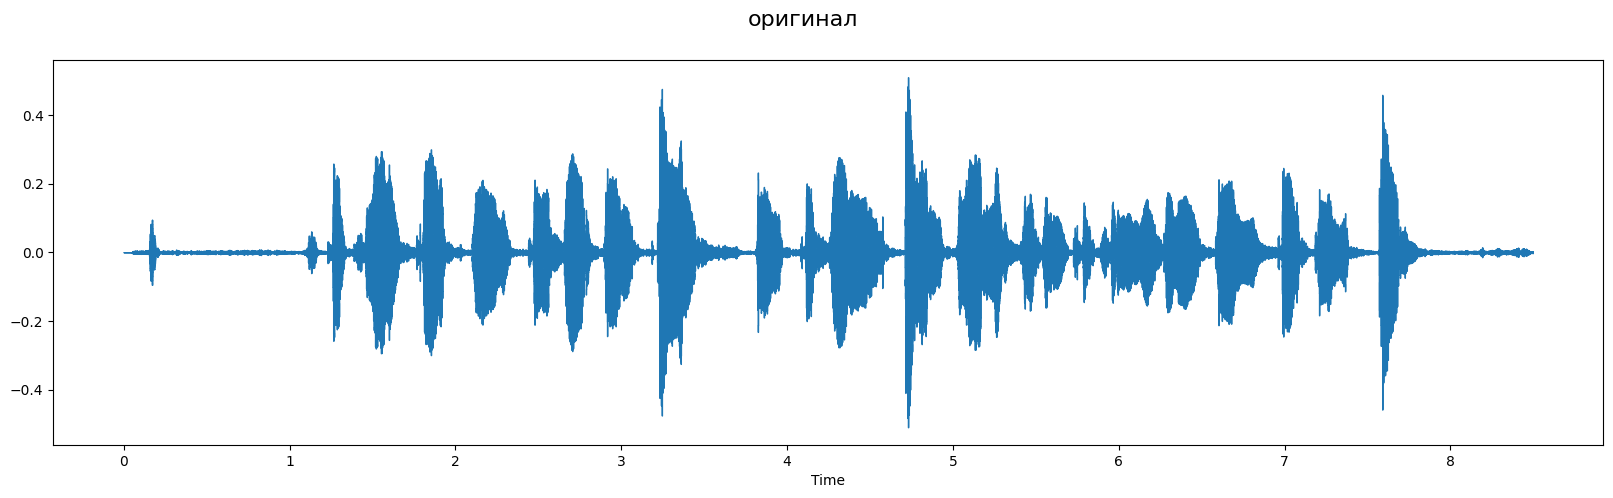

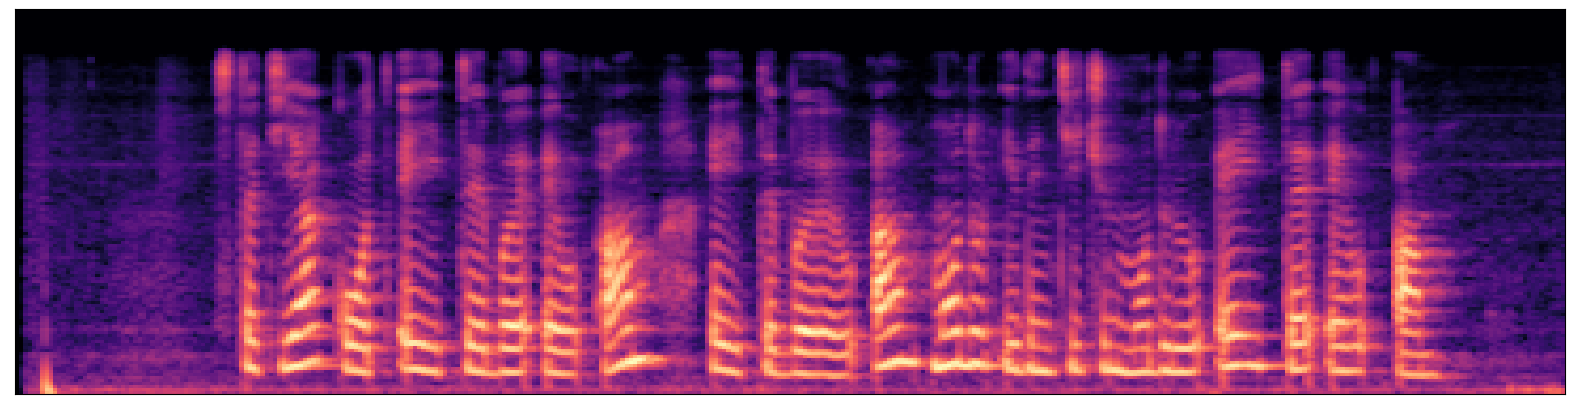

In [25]:
plot_waveform(wav, sr, 'оригинал')
plot_mel(wav, sr)

## white noise

In [26]:
def add_white_noise(signal, noise_percentage_factor=0.2):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

In [27]:
noised_wav = add_white_noise(wav)
noised_audio_path = 'noised.wav'
sf.write(noised_audio_path, noised_wav, sr)
disp.display(disp.Audio(noised_audio_path))

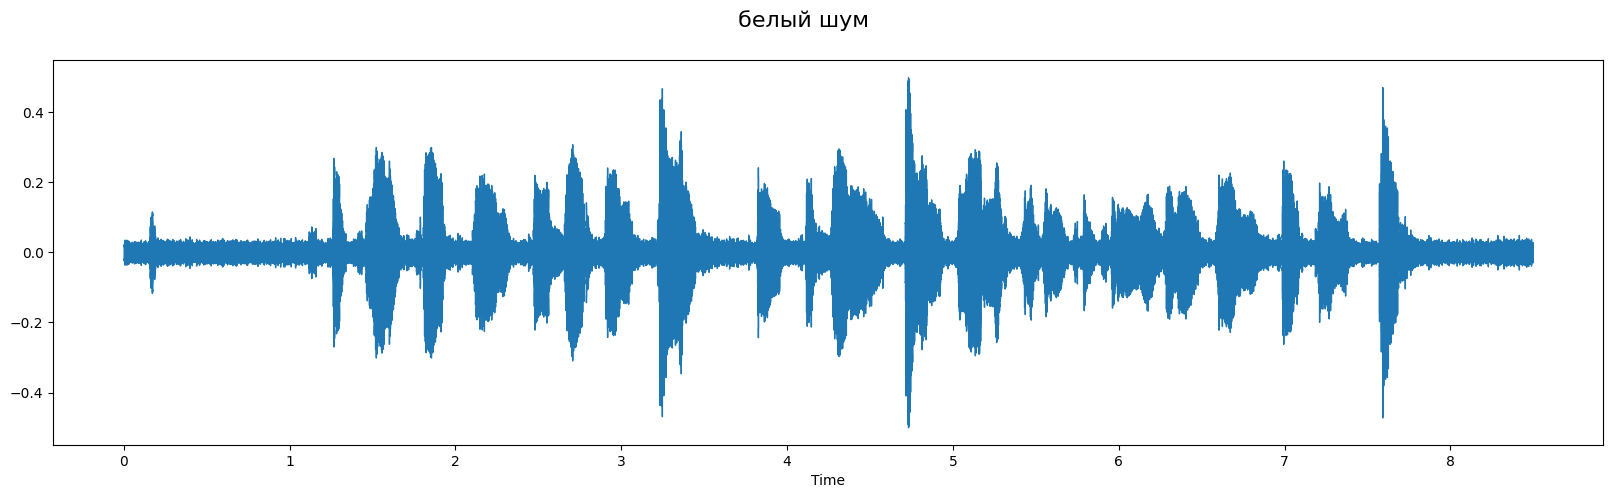

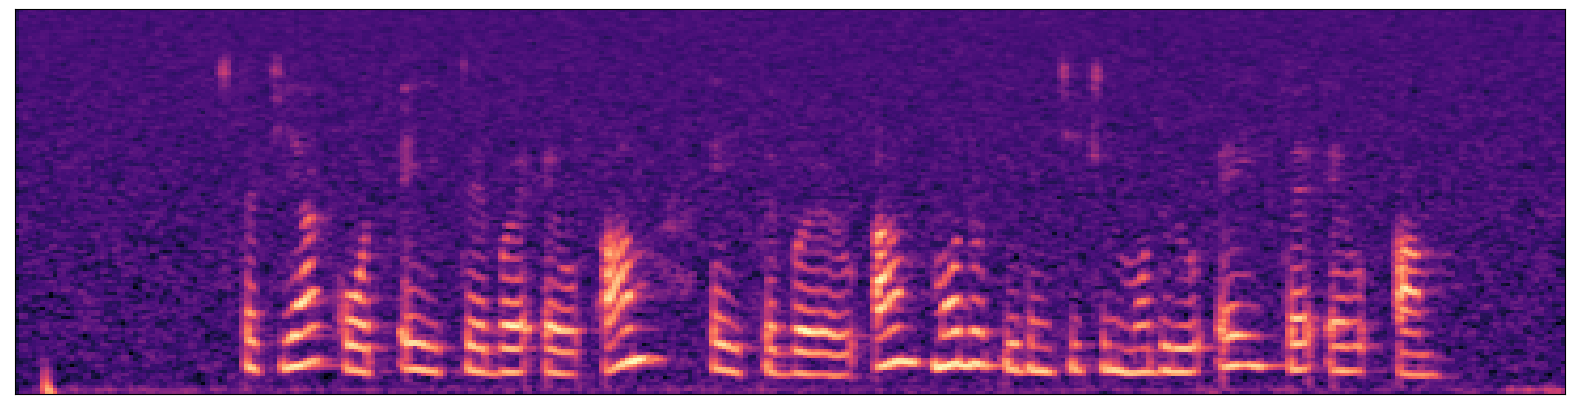

In [28]:
plot_waveform(noised_wav, sr, 'белый шум')
plot_mel(noised_wav, sr)

## prerecorded noise

In [44]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, AddBackgroundNoise, PolarityInversion

In [45]:
sounds_path='../data/sounds/'

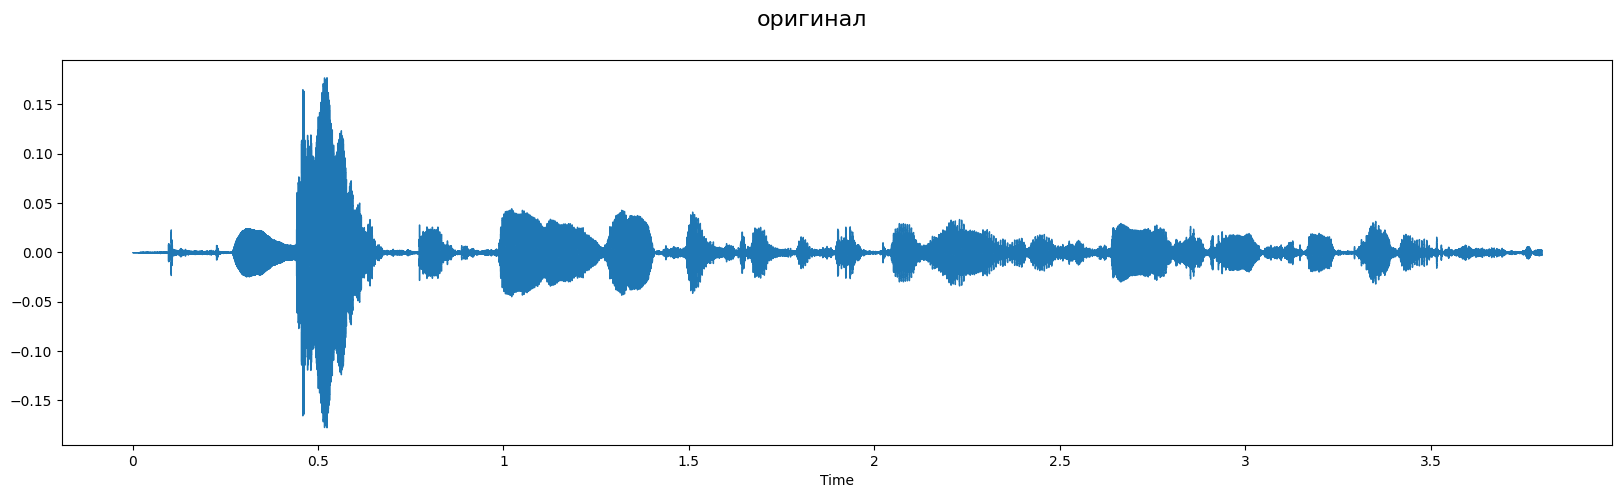

scratch.wav


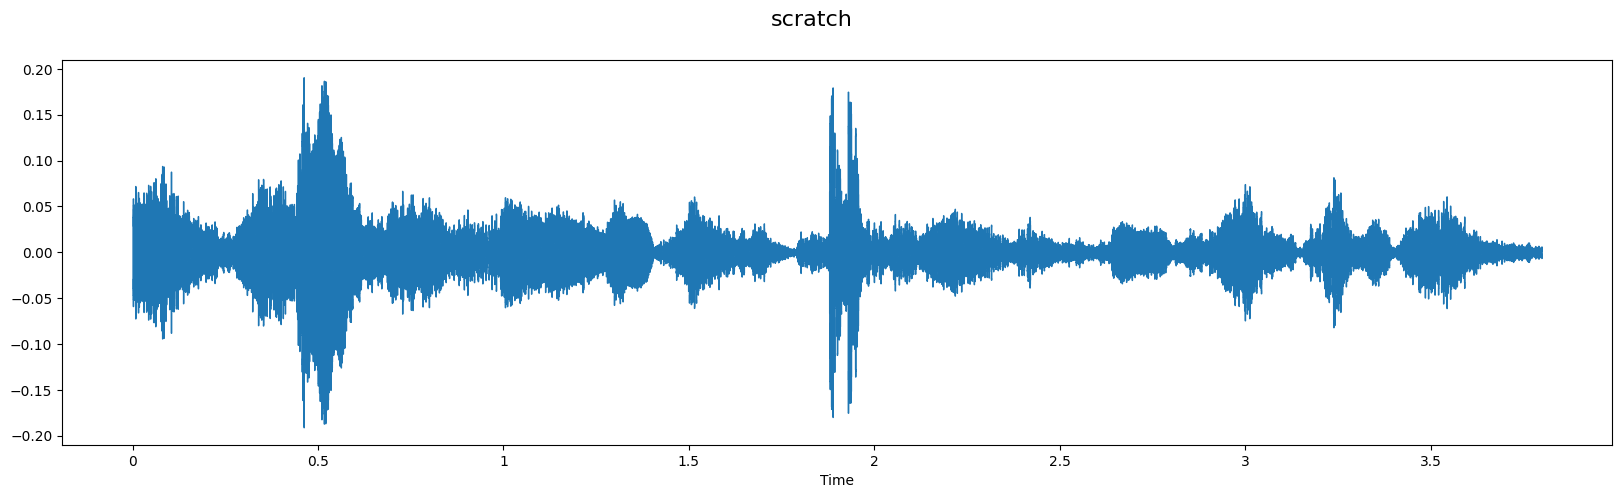

clothes.wav


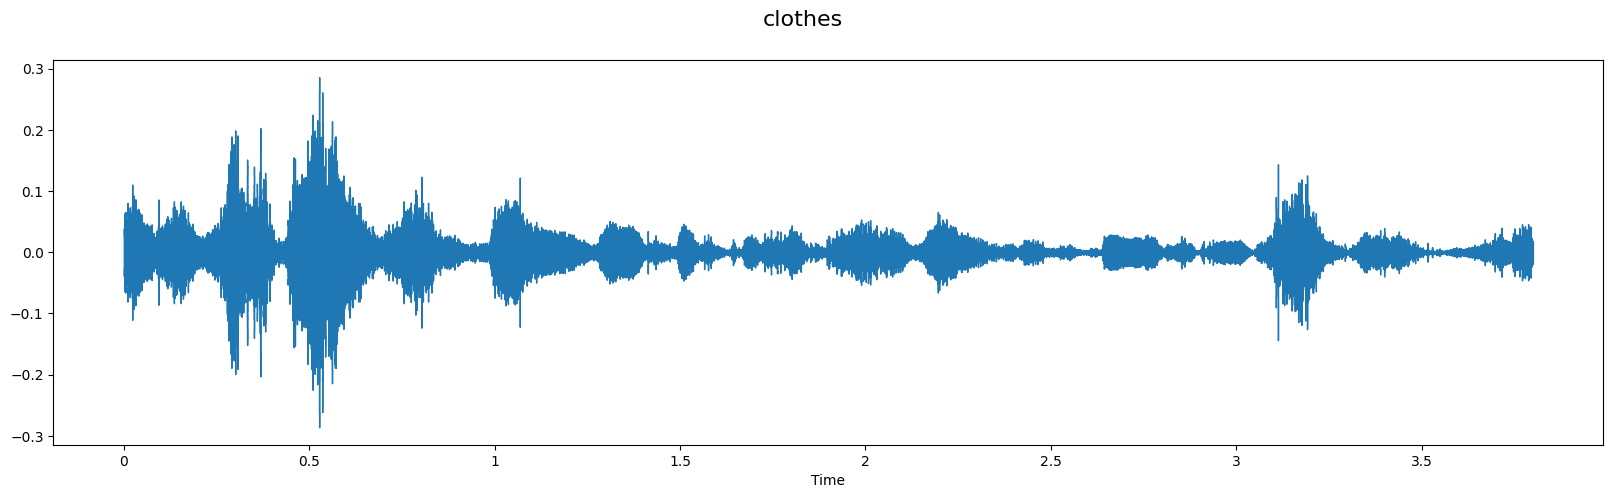

laugh.wav


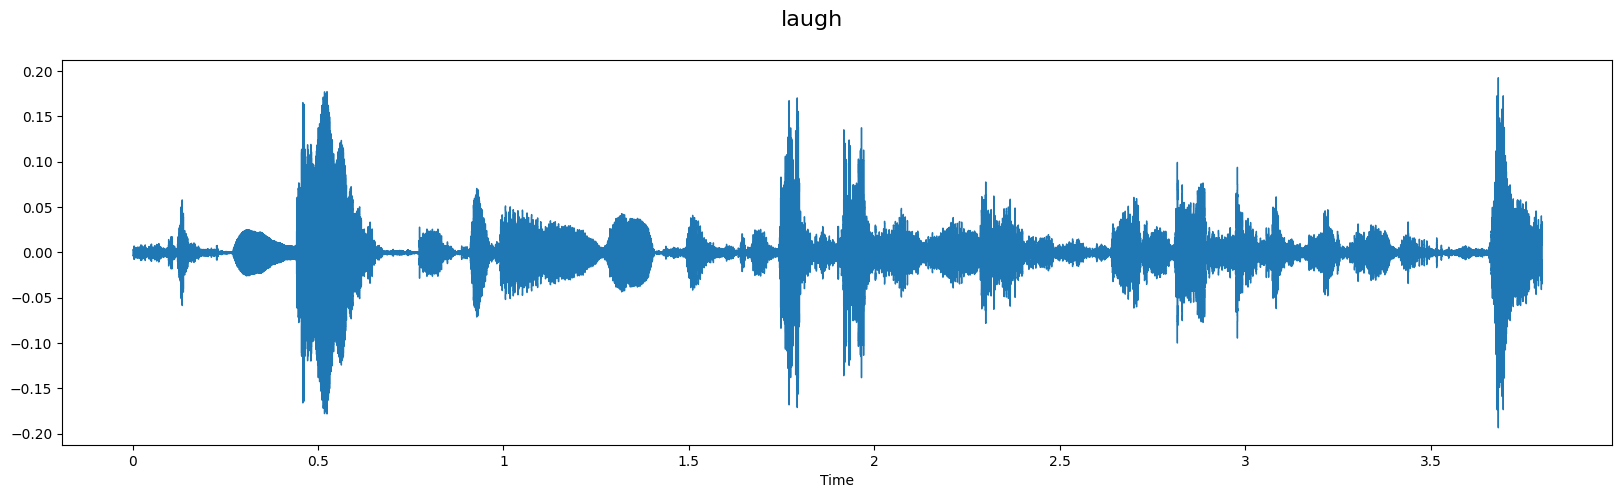

scratch_2.wav


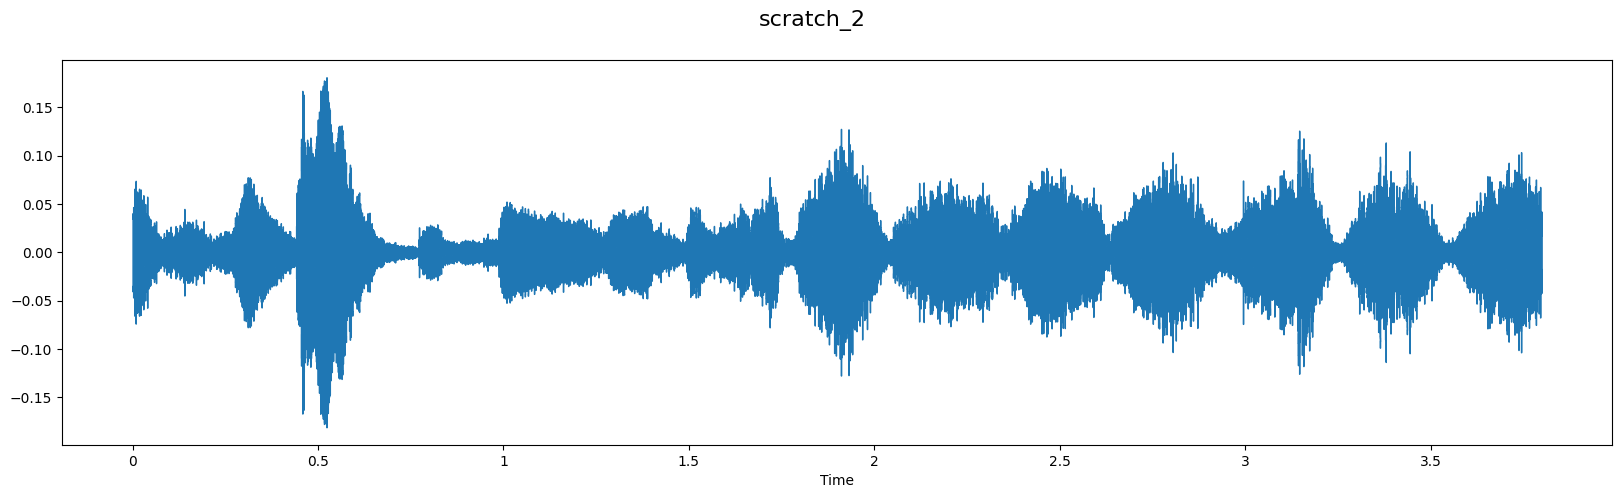

cough.wav


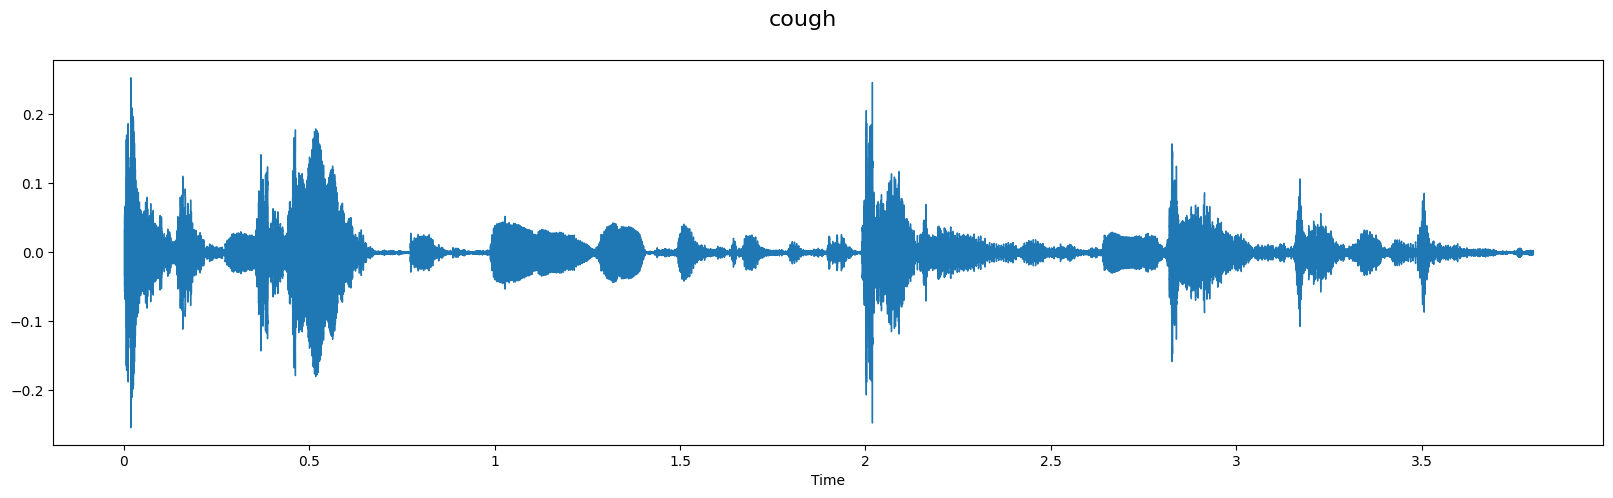

sneeze.wav


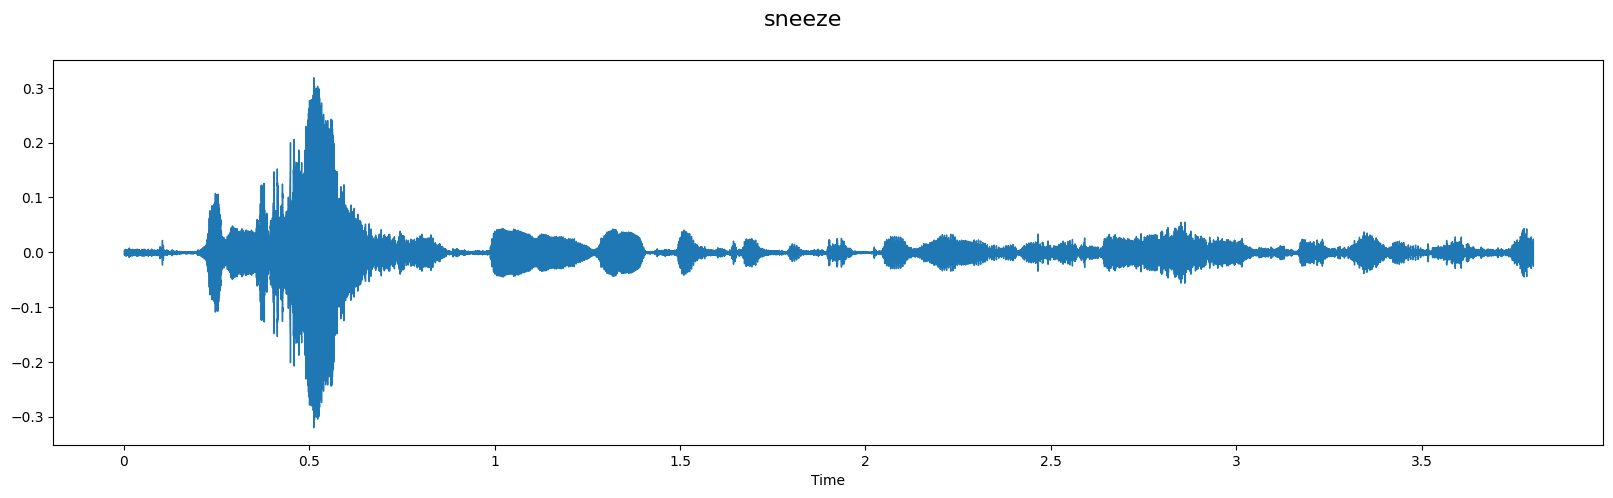

beat.wav


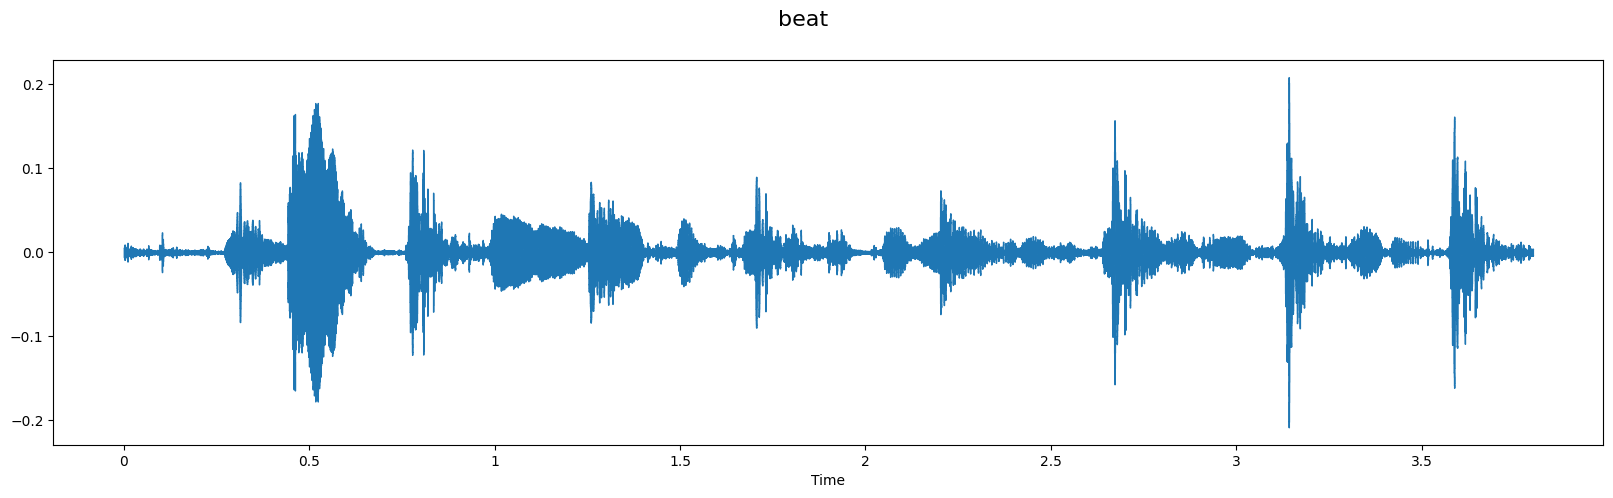

chuavning.wav


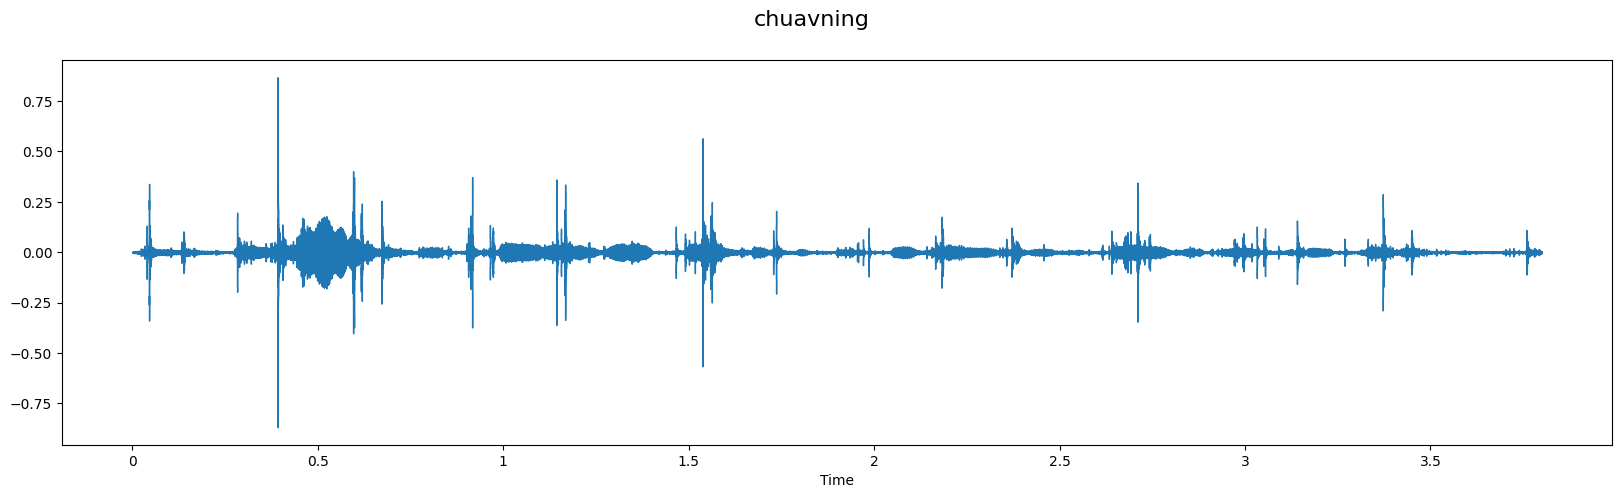

claps.wav


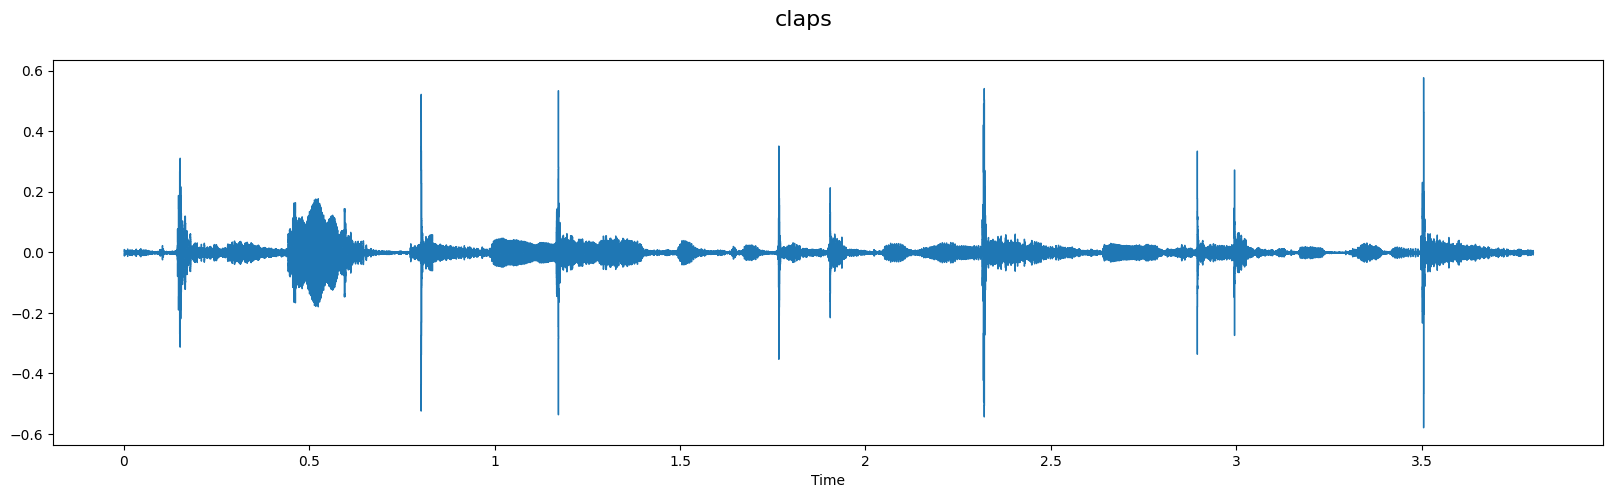

In [46]:
sound_names = os.listdir(sounds_path)
plot_waveform(wav, sr, label='оригинал')
disp.display(disp.Audio(path))
plt.show()
for sound_name in sound_names:
    aug_func = AddBackgroundNoise(
        sounds_path=f"{sounds_path}/{sound_name}",
        min_snr_in_db=1/2.0,
        max_snr_in_db=2.0,
        noise_transform=PolarityInversion(),
        p=1.0
    )
    auged_wav = aug_func(wav, sr)
    auged_audio_path = f'auged_{sound_name}'
    sf.write(auged_audio_path, auged_wav, sr)
    print(sound_name)
    disp.display(disp.Audio(auged_audio_path))
    plot_waveform(auged_wav, sr, sound_name.split('.')[0])
    plt.show()

In [47]:
aug_pipeline = Compose([
    AddGaussianNoise(
        min_amplitude=0.005,
        max_amplitude=0.015,
        p=0.5
    ),
    AddBackgroundNoise(
        sounds_path=f"{sounds_path}",
        min_snr_in_db=1/2.0,
        max_snr_in_db=2.0,
        noise_transform=PolarityInversion(),
        p=1.0,
    )
])

In [4]:
SAVE_DIR = '../../dataset'
clean_prefix = 'clean'
noisy_prefix = 'noisy'

In [ ]:
os.makedirs(f'{SAVE_DIR}/{clean_prefix}', exist_ok=True)
os.makedirs(f'{SAVE_DIR}/{noisy_prefix}', exist_ok=True)

In [50]:
from tqdm import tqdm
format_i = f"0{int(np.ceil(np.log10(len(df)))) + 1}d"

new_sr = 16000
for i, fname in tqdm(enumerate(df.path.values), total=len(df)):
    path = f'{DATA_PATH}/{fname}'
    
    wav, sr = librosa.load(path)
    
    new_path_clean = f'{SAVE_DIR}/{clean_prefix}/{format(i, format_i)}.wav'
    new_path_noisy = f'{SAVE_DIR}/{noisy_prefix}/{format(i, format_i)}.wav'
    auged_wav = aug_pipeline(wav, sr)
    
    wav = librosa.resample(wav, sr, new_sr)
    auged_wav = librosa.resample(auged_wav, sr, new_sr)

    sf.write(new_path_clean, wav, new_sr)    
    sf.write(new_path_noisy, auged_wav, new_sr)

100%|██████████████████████████████████████████████████████| 1000/1000 [14:06<00:00,  1.18it/s]


In [11]:
clean_files = sorted(get_files(f'{SAVE_DIR}/{clean_prefix}'))
noisy_files = sorted(get_files(f'{SAVE_DIR}/{noisy_prefix}'))

In [18]:
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(range(len(clean_files)), test_size=0.2)

In [20]:
train_ann = ''
for i in train_idx:
    train_ann += clean_files[i] + ' ' + noisy_files[i] + '\n'
with open(f'{SAVE_DIR}/train.txt', 'w') as f:
    f.write(train_ann)

In [21]:
val_ann = ''
for i in val_idx:
    val_ann += clean_files[i] + ' ' + noisy_files[i] + '\n'
with open(f'{SAVE_DIR}/val.txt', 'w') as f:
    f.write(val_ann)

In [23]:
print(val_ann)

../../dataset/clean/0176.wav ../../dataset/noisy/0176.wav
../../dataset/clean/0047.wav ../../dataset/noisy/0047.wav
../../dataset/clean/0529.wav ../../dataset/noisy/0529.wav
../../dataset/clean/0832.wav ../../dataset/noisy/0832.wav
../../dataset/clean/0610.wav ../../dataset/noisy/0610.wav
../../dataset/clean/0116.wav ../../dataset/noisy/0116.wav
../../dataset/clean/0686.wav ../../dataset/noisy/0686.wav
../../dataset/clean/0151.wav ../../dataset/noisy/0151.wav
../../dataset/clean/0366.wav ../../dataset/noisy/0366.wav
../../dataset/clean/0858.wav ../../dataset/noisy/0858.wav
../../dataset/clean/0036.wav ../../dataset/noisy/0036.wav
../../dataset/clean/0947.wav ../../dataset/noisy/0947.wav
../../dataset/clean/0022.wav ../../dataset/noisy/0022.wav
../../dataset/clean/0591.wav ../../dataset/noisy/0591.wav
../../dataset/clean/0877.wav ../../dataset/noisy/0877.wav
../../dataset/clean/0624.wav ../../dataset/noisy/0624.wav
../../dataset/clean/0280.wav ../../dataset/noisy/0280.wav
../../dataset/